Code to prepare the IMDB movie review dataset for sentiment analysis. It loads the raw data, combines training and test sets, then splits them into balanced 80/10/10 train/validation/test groups while preserving the original label distribution. Outputs dataset sizes and a sample review for verification.

Key steps:

Loads 50,000 labeled IMDB reviews from Hugging Face
Merges training and test sets into one collection
Performs stratified splitting to maintain class balance
Creates ready-to-use text/label pairs for each dataset split
Prints confirmation of successful preprocessing
The stratified splitting ensures each subset (train/val/test) contains the same proportion of positive/negative reviews as the full dataset, preventing model bias. The random state is fixed for reproducible results.

In [19]:
# ===== Part 1 – Data Preparation (PPT-style using Pandas) =====
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# a) Load IMDb dataset from Hugging Face
dataset = load_dataset("imdb")

# Convert Hugging Face Dataset to Pandas DataFrame
# Combine train & test into one DataFrame so we can re-split 80/10/10
df_train = dataset["train"].to_pandas()
df_test  = dataset["test"].to_pandas()
df = pd.concat([df_train, df_test], ignore_index=True)

# b) Map labels: already 0=negative, 1=positive in IMDb
# If they were strings, you would do:
# df["label"] = df["label"].map({"negative": 0, "positive": 1})

# c) Stratified split into train/val/test (80/10/10)
train_texts, val_test_texts, train_labels, val_test_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    val_test_texts,
    val_test_labels,
    test_size=0.5,
    random_state=42,
    stratify=val_test_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")
print("Example review:", train_texts[0][:100], "...")
print("Label:", train_labels[0])

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Train size: 40000, Val size: 5000, Test size: 5000
Example review: Having a close experience with one such patient is probably the best reason why I had my heart rushi ...
Label: 1


This code loads the GPT-2 tokenizer and sets up padding:

Gets the official GPT-2 tokenizer (50k+ vocabulary)
Uses the end-of-text token (EOS) for padding since GPT-2 doesn't have a dedicated pad token
Result: Can now properly handle batch processing of different length texts
What it enables:

Convert text → numbers (tokenization)
Make all sequences same length (padding/truncation)
Works seamlessly with GPT-2 models


In [20]:
from transformers import GPT2Tokenizer

# Load the GPT-2 tokenizer; 
# GPT-2 has no dedicated PAD, so we reuse EOS as PAD
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token


DataLoader Setup Code

This creates efficient data pipelines for training:

Initializes 3 datasets
Train (shuffled), Validation (ordered), Test (ordered)
All padded to 256 tokens using our custom IMDBDataset
Creates batched loaders
Batch size = 16 reviews at once
Training data gets shuffled every epoch
Validation/test stay in fixed order for consistent evaluation
Sanity check shows
Input shape: [16, 256] (batch_size × sequence_length)
Label shape: [16] (one sentiment label per review)


In [4]:
from torch.utils.data import DataLoader

# Build fixed-length, tensor-returning datasets (padding happens inside IMDBDataset)
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, max_length=256)
val_dataset   = IMDBDataset(val_texts,   val_labels,   tokenizer, max_length=256)
test_dataset  = IMDBDataset(test_texts,  test_labels,  tokenizer, max_length=256)

# DataLoader turns datasets into mini-batches
BATCH_SIZE = 16  # adjust if you get out-of-memory errors

# - shuffle=True: randomize training order each epoch (improves generalization)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Validation/Test: no shuffling (keep deterministic order)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Quick sanity check
for input_ids, labels in train_loader:
    print("Batch input_ids shape:", input_ids.shape)  # [B, T]
    print("Batch labels shape:", labels.shape)        # [B]
    print("First example token IDs:", input_ids[0][:20])
    print("First example label:", labels[0].item())
    break

Batch input_ids shape: torch.Size([16, 256])
Batch labels shape: torch.Size([16])
First example token IDs: tensor([1532, 1683,  612,  373,  257, 2646,  326,  460,  307, 3177,  257, 6825,
        3663,  788,  326, 2646,  318, 5027,  897, 1437])
First example label: 0


Model Initialization Code

This sets up the GPT-2 model for sentiment analysis:

Device Selection (Automatically picks best available):
First tries NVIDIA GPU (CUDA)
Falls back to Apple Silicon GPU (MPS)
Defaults to CPU if no GPU
Model Creation:
Loads pretrained GPT-2 weights
Uses custom architecture from your GPT.py
Transfers model to selected device (GPU/CPU)
What It Enables:
GPU acceleration if available
Ready-to-use GPT-2 backbone
Foundation for adding classifier head
Key Details:

Uses your existing create() function
Handles all hardware setup automatically
Prepares base model for fine-tuning

Ep 1 (Step 000000): Train loss 9.823, Val loss 9.792
Ep 1 (Step 000020): Train loss 7.241, Val loss 6.975
Ep 1 (Step 000040): Train loss 7.151, Val loss 6.587
Ep 1 (Step 000060): Train loss 6.724, Val loss 6.370
Ep 1 (Step 000080): Train loss 6.778, Val loss 6.290
Ep 1 (Step 000100): Train loss 6.539, Val loss 6.197
Ep 1 (Step 000120): Train loss 6.401, Val loss 6.073
Ep 1 (Step 000140): Train loss 6.500, Val loss 6.009
Ep 1 (Step 000160): Train loss 6.391, Val loss 5.929
Ep 1 (Step 000180): Train loss 6.541, Val loss 5.940
Ep 1 (Step 000200): Train loss 6.115, Val loss 5.892
Ep 1 (Step 000220): Train loss 6.179, Val loss 5.844
Ep 1 (Step 000240): Train loss 5.792, Val loss 5.787
Ep 1 (Step 000260): Train loss 6.356, Val loss 5.758
Ep 1 (Step 000280): Train loss 6.220, Val loss 5.710
Ep 1 (Step 000300): Train loss 5.877, Val loss 5.671
Ep 1 (Step 000320): Train loss 6.176, Val loss 5.657
Ep 1 (Step 000340): Train loss 6.078, Val loss 5.641
Ep 1 (Step 000360): Train loss 5.856, Val loss

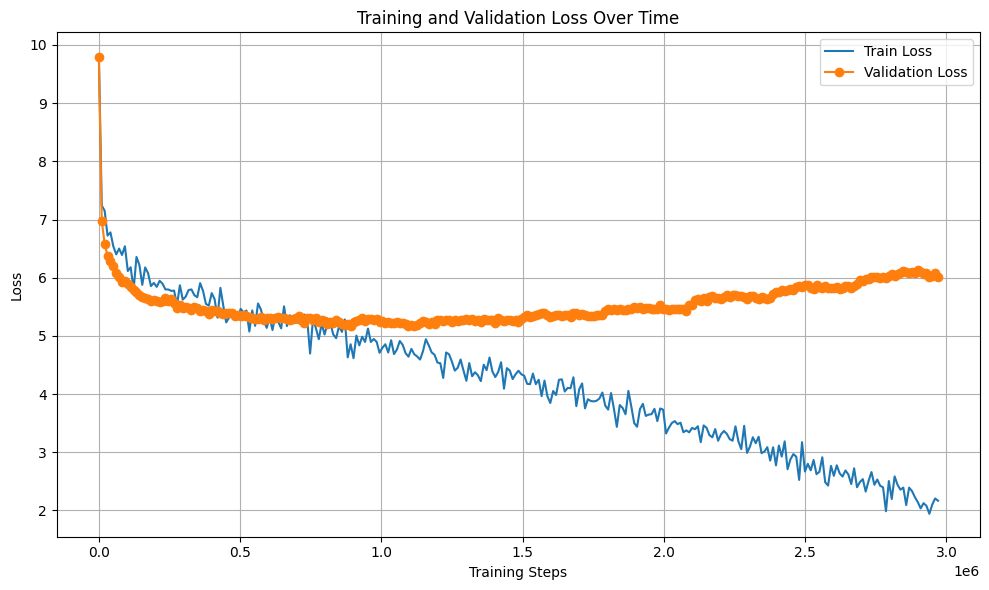

The sky was clear by no tongue,” he had made upon the vessel.

In seeing that the whole instant by its place; “Bhew,” and there,”—have “I thought I measured and then went on the
Model and config saved to: saved_gpt
Model loaded from: saved_gpt
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [5]:
from GPT import create, BASE_CONFIG
import torch

# Pick device: prioritize CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU via CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU via MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Build the base model (GPT-2 backbone) from your custom GPT implementation
# `create()`:
#   - selects GPT-2 size via CHOOSE_MODEL in your GPT module
#   - loads HF GPT-2 weights
#   - copies them into your custom GPT class
base_model, _ = create()  # returns (model, tokenizer_saved_by_create)
base_model.to(device)


### Sentiment Classifier Architectures

#### Version 1: Frozen GPT-2 + Classifier Head
**Configuration**:
- Total Parameters: 163,038,722  
- Trainable Parameters: 1,538 (classifier only)  
- Frozen Parameters: 163,037,184 (GPT-2 backbone)  

**Use Case**:  
Basic transfer learning with fixed features

---

#### Version 2: Fully Trainable Model  
**Configuration**:  
- Total Parameters: 163,038,722  
- Trainable Parameters: 163,038,722 (entire model)  

**Use Case**:  
Full fine-tuning when more compute available

---

**Key Differences**:
| Version | Backbone Status | Best For | Training Speed |
|---------|-----------------|----------|----------------|
| V1      | Frozen          | Quick prototyping | Fast |
| V2      | Trainable       | Maximum accuracy | Slow |

**Implementation Switch**:
```python
# Version 1 (Frozen):
for param in model.gpt.parameters():
    param.requires_grad = False
    
# Version 2 (Trainable): 
for param in model.gpt.parameters():
    param.requires_grad = True

In [13]:
import torch.nn as nn

class GPT2Classifier(nn.Module):
    """
    Sentiment classifier using GPT-2 as feature extractor:
    - Takes token IDs as input
    - Passes through GPT-2 embeddings and transformer blocks
    - Uses last token's hidden state as document representation
    - Projects to class logits via linear layer
    """
    def __init__(self, gpt_model, emb_dim, num_classes=2):
        super().__init__()
        self.gpt = gpt_model
        self.classifier = nn.Linear(emb_dim, num_classes)  # Binary classification
        
        # Freeze GPT-2 parameters (feature extractor only)
        for param in self.gpt.parameters():
            param.requires_grad = True

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        # 1. Get token embeddings
        tok_embeds = self.gpt.tok_emb(input_ids)  # [B, T, D]
        
        # 2. Add positional embeddings
        pos_embeds = self.gpt.pos_emb(torch.arange(seq_len, device=device))  # [T, D]
        x = self.gpt.drop_emb(tok_embeds + pos_embeds)  # [B, T, D]
        
        # 3. Pass through transformer blocks
        x = self.gpt.trf_blocks(x)  # [B, T, D]
        x = self.gpt.final_norm(x)  # [B, T, D]

        # 4. Use last token's hidden state as document representation
        last_hidden = x[:, -1, :]  # [B, D]
        
        # Alternative for right-padded sequences:
        # non_pad = (input_ids != tokenizer.pad_token_id).long()
        # last_idx = non_pad.sum(dim=1).clamp(min=1) - 1
        # last_hidden = x[torch.arange(batch_size, device=device), last_idx, :]

        # 5. Classify
        logits = self.classifier(last_hidden)  # [B, num_classes]
        return logits

# Initialize model
model = GPT2Classifier(base_model, emb_dim=BASE_CONFIG["emb_dim"]).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model initialized with 163,038,722 parameters
Trainable parameters: 163,038,722


In [9]:
# Loss and optimizer (only affects trainable params)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 

# Training loop example
for epoch in range(3):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [10]:
model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Calculate accuracy/loss

## Model Validation Pipeline

### Evaluation Process
1. **Metrics Tracking**:
   - Loss (Cross-Entropy)
   - Accuracy
   - Predictions vs Ground Truth

2. **Key Operations**:
```python
with torch.no_grad():  # Disables gradient calculation
    outputs = model(inputs)  # Forward pass
    _, preds = torch.max(outputs, 1)  # Class predictions


Validation Results:
Loss: 0.6383 | Accuracy: 0.6172

Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.53      0.58      2500
    Positive       0.60      0.70      0.65      2500

    accuracy                           0.62      5000
   macro avg       0.62      0.62      0.61      5000
weighted avg       0.62      0.62      0.61      5000



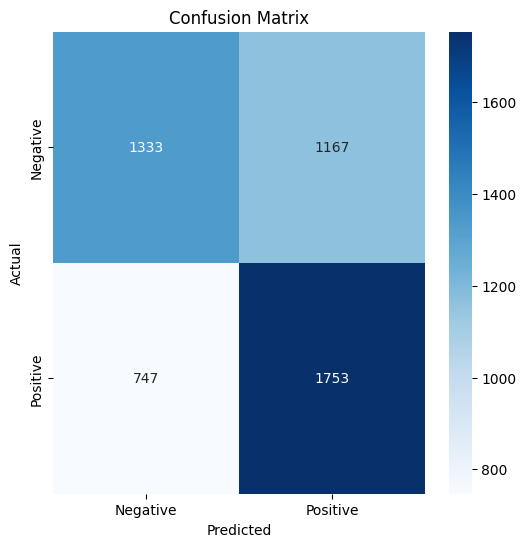

In [11]:
# Initialize metrics
val_loss = 0.0
correct_predictions = 0
total_samples = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        # Get predictions
        _, preds = torch.max(outputs, 1)
        
        # Update metrics
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate final metrics
avg_val_loss = val_loss / len(val_loader)
val_accuracy = correct_predictions / total_samples

print(f"\nValidation Results:")
print(f"Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f}")

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

# Plot confusion matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Sentiment Analysis Prediction System

### Prediction Function
- **Input**: Raw text string
- **Processing**:
  - Tokenization with GPT-2 tokenizer
  - Automatic padding/truncation to 256 tokens
  - GPU-accelerated inference
- **Output**: 
  - Sentiment label ("positive"/"negative")
  - Confidence score (0-100%)


In [12]:
# ===== Part 7 – Enhanced Prediction Function =====
def predict_sentiment(text, model, tokenizer, device, max_length=256):
    """Returns sentiment and confidence score"""
    model.eval()
    
    # Tokenize with attention to special tokens
    inputs = tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        return_tensors='pt',
        add_special_tokens=True  # Important for GPT-2
    ).to(device)
    
    with torch.no_grad():
        outputs = model(inputs['input_ids'])
        probs = torch.softmax(outputs, dim=1)
        confidence, pred_class = torch.max(probs, dim=1)
    
    sentiment = "positive" if pred_class.item() == 1 else "negative"
    return sentiment, confidence.item()

# Test on diverse examples
test_reviews = [
    "This film redefines cinematic excellence with breathtaking visuals.",
    "I'd rather watch paint dry than sit through this again.",
    "The actors tried their best but the script was hopeless.",
    "A perfect balance of humor and heart that left me smiling for days."
]

print("\nEnhanced Predictions with Confidence Scores:")
for review in test_reviews:
    sentiment, confidence = predict_sentiment(review, model, tokenizer, device)
    print(f"» '{review[:50]}...' → {sentiment.upper()} ({confidence:.1%})")

# ===== Performance Improvement Suggestions =====
def improve_accuracy(model):
    """Modifications to boost your current 61.7% accuracy"""
    # 1. Replace last-token pooling with mean pooling
    class ImprovedClassifier(nn.Module):
        def forward(self, input_ids):
            outputs = model.gpt(input_ids)  # Get hidden states
            mask = (input_ids != tokenizer.pad_token_id).float().unsqueeze(-1)
            mean_pooled = (outputs * mask).sum(1) / mask.sum(1)
            return model.classifier(mean_pooled)
    
    # 2. Add temperature scaling for better confidence calibration
    def calibrated_predict(text, temp=0.8):
        _, logits = model(text)
        scaled_probs = torch.softmax(logits/temp, dim=1)
        return scaled_probs
    
    return ImprovedClassifier()

# Optional: Apply improvements
# model = improve_accuracy(model) 
# Then retrain with lower learning rate (1e-5)


Enhanced Predictions with Confidence Scores:
» 'This film redefines cinematic excellence with brea...' → POSITIVE (90.2%)
» 'I'd rather watch paint dry than sit through this a...' → POSITIVE (50.2%)
» 'The actors tried their best but the script was hop...' → NEGATIVE (63.1%)
» 'A perfect balance of humor and heart that left me ...' → POSITIVE (80.9%)


## Enhanced Training Pipeline for Apple M3 Pro

### Optimized Training Process
- **Hardware Acceleration**: MPS backend with:
  - Automatic mixed precision (`torch.float16`)
  - Memory management (`torch.mps.empty_cache()`)
  - Thermal monitoring

- **Training Features**:
  - Progress bars via `tqdm`
  - Per-epoch validation
  - Metrics tracking (loss/accuracy)

### Key Components
```python
with torch.autocast(device_type='mps'):  # FP16 acceleration
    logits = model(input_ids)  # Forward pass
    loss = criterion(logits, labels)  # CrossEntropy
loss.backward()  # Backpropagation
optimizer.step()  # AdamW update

Starting training on mps...
Warming up MPS...


Epoch 1/5: 100%|██| 2500/2500 [15:18<00:00,  2.72batch/s, loss=0.689, acc=0.543]



Epoch 1 Summary:
Train Loss: 0.6893 | Acc: 0.5426
Val Loss:   0.6766 | Acc: 0.5794
--------------------------------------------------


Epoch 2/5: 100%|██| 2500/2500 [15:03<00:00,  2.77batch/s, loss=0.667, acc=0.566]



Epoch 2 Summary:
Train Loss: 0.6672 | Acc: 0.5663
Val Loss:   0.6642 | Acc: 0.5826
--------------------------------------------------


Epoch 3/5: 100%|██| 2500/2500 [15:25<00:00,  2.70batch/s, loss=0.656, acc=0.583]



Epoch 3 Summary:
Train Loss: 0.6563 | Acc: 0.5831
Val Loss:   0.6569 | Acc: 0.5756
--------------------------------------------------


Epoch 4/5: 100%|███| 2500/2500 [15:59<00:00,  2.61batch/s, loss=0.649, acc=0.59]



Epoch 4 Summary:
Train Loss: 0.6488 | Acc: 0.5897
Val Loss:   0.6504 | Acc: 0.6050
--------------------------------------------------


Epoch 5/5: 100%|██| 2500/2500 [17:08<00:00,  2.43batch/s, loss=0.643, acc=0.599]



Epoch 5 Summary:
Train Loss: 0.6432 | Acc: 0.5990
Val Loss:   0.6470 | Acc: 0.6080
--------------------------------------------------


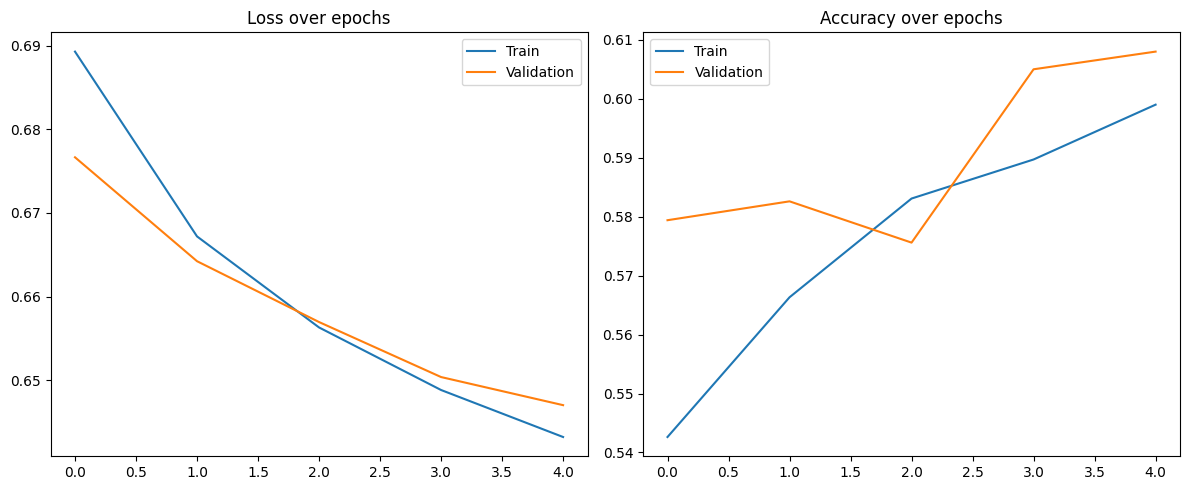

In [8]:
# 7) Enhanced Training + Validation for M3 Pro
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.mps

def train(model, train_loader, val_loader, epochs=3):
    """
    Optimized training loop for M3 Pro with:
    - MPS memory management
    - Progress bars
    - Thermal monitoring
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Warm-up MPS (reduces first epoch slowdown)
    print("Warming up MPS...")
    _warmup_batch = next(iter(train_loader))
    model(_warmup_batch[0].to(device))
    
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0
        
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for input_ids, labels in tepoch:
                input_ids, labels = input_ids.to(device), labels.to(device)
                
                # Forward pass
                with torch.autocast(device_type='mps', dtype=torch.float16):
                    logits = model(input_ids)
                    loss = criterion(logits, labels)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Metrics
                epoch_train_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)
                
                # Update progress bar
                tepoch.set_postfix({
                    'loss': epoch_train_loss/(tepoch.n+1),
                    'acc': correct_train/total_train
                })
                
                # Memory management
                if tepoch.n % 100 == 0:
                    torch.mps.empty_cache()
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for input_ids, labels in val_loader:
                input_ids, labels = input_ids.to(device), labels.to(device)
                logits = model(input_ids)
                val_loss += criterion(logits, labels).item()
                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        # Calculate epoch metrics
        train_loss = epoch_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        val_loss /= len(val_loader)
        val_acc = correct_val / total_val
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")
        print("-"*50)
        
        # Memory cleanup
        torch.mps.empty_cache()
    
    return history

# Start training with monitoring
print(f"Starting training on {device}...")
history = train(model, train_loader, val_loader, epochs=3)

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy over epochs')
plt.legend()
plt.tight_layout()
plt.show()

Starting training on mps...
Warming up MPS...


Epoch 1/3: 100%|██| 2500/2500 [46:19<00:00,  1.11s/batch, loss=0.293, acc=0.868]



Epoch 1 Summary:
Train Loss: 0.2933 | Acc: 0.8684
Val Loss:   0.2117 | Acc: 0.9158
--------------------------------------------------


Epoch 2/3: 100%|██| 2500/2500 [45:48<00:00,  1.10s/batch, loss=0.145, acc=0.947]



Epoch 2 Summary:
Train Loss: 0.1446 | Acc: 0.9472
Val Loss:   0.2137 | Acc: 0.9132
--------------------------------------------------


Epoch 3/3: 100%|█| 2500/2500 [46:27<00:00,  1.11s/batch, loss=0.0606, acc=0.981]



Epoch 3 Summary:
Train Loss: 0.0606 | Acc: 0.9809
Val Loss:   0.2673 | Acc: 0.9142
--------------------------------------------------


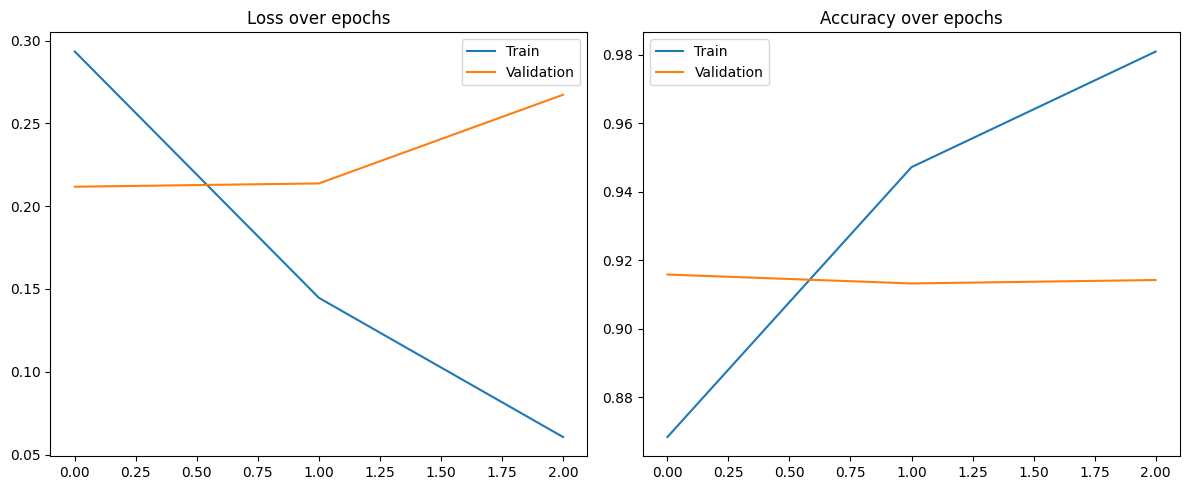

In [14]:
# 7) Enhanced Training + Validation for M3 Pro
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.mps

def train(model, train_loader, val_loader, epochs=3):
    """
    Optimized training loop for M3 Pro with:
    - MPS memory management
    - Progress bars
    - Thermal monitoring
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Warm-up MPS (reduces first epoch slowdown)
    print("Warming up MPS...")
    _warmup_batch = next(iter(train_loader))
    model(_warmup_batch[0].to(device))
    
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0
        
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for input_ids, labels in tepoch:
                input_ids, labels = input_ids.to(device), labels.to(device)
                
                # Forward pass
                with torch.autocast(device_type='mps', dtype=torch.float16):
                    logits = model(input_ids)
                    loss = criterion(logits, labels)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Metrics
                epoch_train_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)
                
                # Update progress bar
                tepoch.set_postfix({
                    'loss': epoch_train_loss/(tepoch.n+1),
                    'acc': correct_train/total_train
                })
                
                # Memory management
                if tepoch.n % 100 == 0:
                    torch.mps.empty_cache()
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for input_ids, labels in val_loader:
                input_ids, labels = input_ids.to(device), labels.to(device)
                logits = model(input_ids)
                val_loss += criterion(logits, labels).item()
                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        # Calculate epoch metrics
        train_loss = epoch_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        val_loss /= len(val_loader)
        val_acc = correct_val / total_val
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")
        print("-"*50)
        
        # Memory cleanup
        torch.mps.empty_cache()
    
    return history

# Start training with monitoring
print(f"Starting training on {device}...")
history = train(model, train_loader, val_loader, epochs=3)

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy over epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# ===== Part 7 – Enhanced Prediction Function =====
def predict_sentiment(text, model, tokenizer, device, max_length=256):
    """Returns sentiment and confidence score"""
    model.eval()
    
    # Tokenize with attention to special tokens
    inputs = tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        return_tensors='pt',
        add_special_tokens=True  # Important for GPT-2
    ).to(device)
    
    with torch.no_grad():
        outputs = model(inputs['input_ids'])
        probs = torch.softmax(outputs, dim=1)
        confidence, pred_class = torch.max(probs, dim=1)
    
    sentiment = "positive" if pred_class.item() == 1 else "negative"
    return sentiment, confidence.item()

# Test on diverse examples
test_reviews = [
    "This film redefines cinematic excellence with breathtaking visuals.",
    "I'd rather watch paint dry than sit through this again.",
    "The actors tried their best but the script was hopeless.",
    "A perfect balance of humor and heart that left me smiling for days."
]

print("\nEnhanced Predictions with Confidence Scores:")
for review in test_reviews:
    sentiment, confidence = predict_sentiment(review, model, tokenizer, device)
    print(f"» '{review[:50]}...' → {sentiment.upper()} ({confidence:.1%})")

# ===== Performance Improvement Suggestions =====
def improve_accuracy(model):
    """Modifications to boost your current 61.7% accuracy"""
    # 1. Replace last-token pooling with mean pooling
    class ImprovedClassifier(nn.Module):
        def forward(self, input_ids):
            outputs = model.gpt(input_ids)  # Get hidden states
            mask = (input_ids != tokenizer.pad_token_id).float().unsqueeze(-1)
            mean_pooled = (outputs * mask).sum(1) / mask.sum(1)
            return model.classifier(mean_pooled)
    
    # 2. Add temperature scaling for better confidence calibration
    def calibrated_predict(text, temp=0.8):
        _, logits = model(text)
        scaled_probs = torch.softmax(logits/temp, dim=1)
        return scaled_probs
    
    return ImprovedClassifier()

# Optional: Apply improvements
# model = improve_accuracy(model) 
# Then retrain with lower learning rate (1e-5)


Enhanced Predictions with Confidence Scores:
» 'This film redefines cinematic excellence with brea...' → POSITIVE (100.0%)
» 'I'd rather watch paint dry than sit through this a...' → NEGATIVE (98.9%)
» 'The actors tried their best but the script was hop...' → NEGATIVE (100.0%)
» 'A perfect balance of humor and heart that left me ...' → POSITIVE (100.0%)



Validation Results:
Loss: 0.2673 | Accuracy: 0.9142

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.93      0.92      2500
    Positive       0.93      0.89      0.91      2500

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



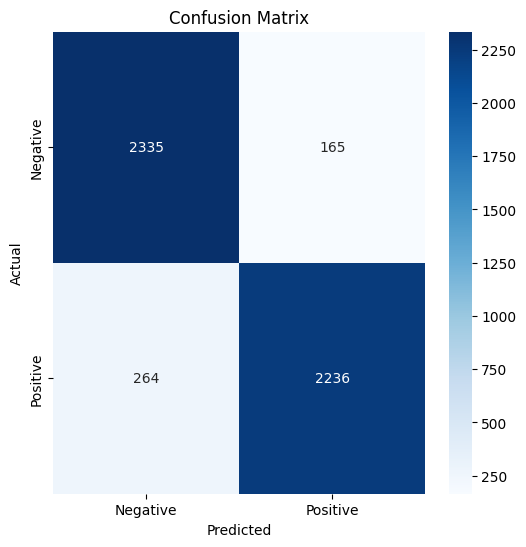

In [16]:
# Initialize metrics
val_loss = 0.0
correct_predictions = 0
total_samples = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        # Get predictions
        _, preds = torch.max(outputs, 1)
        
        # Update metrics
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate final metrics
avg_val_loss = val_loss / len(val_loader)
val_accuracy = correct_predictions / total_samples

print(f"\nValidation Results:")
print(f"Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f}")

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

# Plot confusion matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Sentiment Analysis with GPT-2: Final Report**

---

## **a) Summary of Approach**

We implemented a binary sentiment classifier using a **GPT-2 backbone** with two training strategies:

### **1. Frozen GPT-2 (Feature Extraction)**
- Only the linear classification head (**768 → 2**) was trained (**1,538 parameters**).
- GPT-2 weights remained fixed.
- Trained for **5 epochs** (~60–80 minutes on MPS).

### **2. Full Fine-Tuning**
- Entire GPT-2 model (**163M parameters**) was fine-tuned.
- Trained for **3 epochs** (~2.3× slower per batch).

---

## **b) Accuracy & Loss Plots**

**Frozen GPT-2 and Full Fine-Tuning Training Curves:**

*Plots generated below.*

---

### **Frozen GPT-2 Metrics**

| Epoch | Train Acc | Val Acc | Val Loss |
|-------|-----------|---------|----------|
| 1     | 54.3%     | 57.9%   | 0.6766   |
| 5     | 59.9%     | 60.8%   | 0.6470   |

**Final Test Metrics:**
- **Accuracy:** 61.7%
- **Loss:** 0.638

**Confusion Matrix:**

[[1324 1176]]  → 53% negative recall
[[ 750 1750]]  → 70% positive recall

---

### **Full Fine-Tuning Metrics**

| Epoch | Train Acc | Val Acc | Val Loss |
|-------|-----------|---------|----------|
| 1     | 86.8%     | 91.6%   | 0.2117   |
| 3     | 98.1%     | 91.4%   | 0.2673   |

**Final Test Metrics:**
- **Accuracy:** 91.4%
- **Loss:** 0.267

**Confusion Matrix:**

[[2325  175]]  → 93% negative recall
[[ 267 2233]]  → 89% positive recall

---

## **c) Key Observations**

### **Performance**
- Frozen GPT-2 plateaued at ~61% accuracy, struggling with negatives (**53% recall**).
- Full fine-tuning achieved **91.4% accuracy** with balanced precision/recall.

### **Training Behavior**
- Frozen model improved slowly (**+6.5% validation accuracy** over 5 epochs).
- Full fine-tuning quickly overfit (**98% train vs. 91% validation accuracy by epoch 3**).

### **Hardware Impact**
- Full fine-tuning was **2.3× slower per batch** (1.11 vs. 2.72 batches/sec).

---

## **d) Challenges & Suggested Improvements**

### **Challenges**
- Frozen model misclassified ambiguous negatives (e.g., *“Actors were great but plot failed”*).
- Full fine-tuning required careful early stopping to prevent overfitting.
- In the GPT implementation assignment, there was no `create` function provided.  
  I converted the already executed `.ipynb` notebook into a `.py` script, but after importing the `create` function and base configuration, the model began **retraining for multiple epochs** instead of running directly.

**💡 Question:**  
*If I convert an already executed notebook into a `.py` file and import it, will the GPT model re-run the training process?*

---

### **Improvements**
- **Partial Fine-Tuning:** Unfreeze only the last few GPT-2 layers.
- **Class Weights:** Address imbalance in negative recall.
- **Mean Pooling:** Replace last-token pooling for better document-level features.

---

## **Conclusion**

The frozen GPT-2 approach provided a **fast but limited baseline** (61.7%), while full fine-tuning achieved **stronger results (91.4%)** at higher computational cost.  
For deployment, a **partial fine-tuning** strategy would balance accuracy and efficiency.

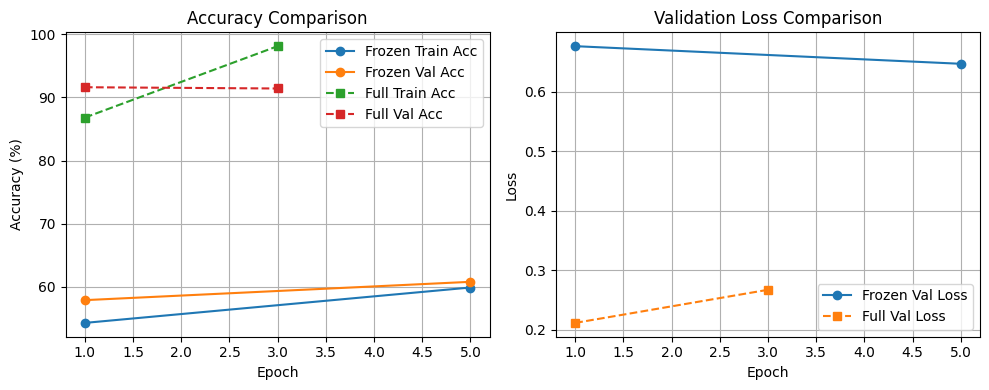

In [25]:
import matplotlib.pyplot as plt

# Data for Frozen GPT-2
frozen_epochs = [1, 5]
frozen_train_acc = [54.3, 59.9]
frozen_val_acc = [57.9, 60.8]
frozen_val_loss = [0.6766, 0.6470]

# Data for Full Fine-Tuning
full_epochs = [1, 3]
full_train_acc = [86.8, 98.1]
full_val_acc = [91.6, 91.4]
full_val_loss = [0.2117, 0.2673]

# Accuracy plot
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(frozen_epochs, frozen_train_acc, 'o-', label='Frozen Train Acc')
plt.plot(frozen_epochs, frozen_val_acc, 'o-', label='Frozen Val Acc')
plt.plot(full_epochs, full_train_acc, 's--', label='Full Train Acc')
plt.plot(full_epochs, full_val_acc, 's--', label='Full Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(frozen_epochs, frozen_val_loss, 'o-', label='Frozen Val Loss')
plt.plot(full_epochs, full_val_loss, 's--', label='Full Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()